In [47]:
#!/usr/bin/env python

from collections import deque
import time
import random
import os
import glob
import re

import numpy as np
import gym
import h5py

import cv2
from skimage.transform import rescale

# ROS packages required
import rospy
import rospkg

from keras.models import load_model

from neuroracer_gym.tasks import neuroracer_discrete_task
from neuroracer_gym_rl.scripts.utils import preprocess

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class PolarRay:
    def __init__(self, n_rays, min_angle, max_angle):
        self.min_a = min_angle
        self.max_a = max_angle
        self.n = n_rays
        self.l = np.abs(min_angle) + np.abs(max_angle)
        self.lh = self.l/2
        
    def ray_to_rad(self, ray_idx):
        return (self.lh-ray_idx*self.l/self.n)

    def ray_to_degree(self, ray_idx):
        return self.ray_to_rad(ray_idx)*180/np.pi

    def degree_to_ray(self, degree):
        return np.round((self.lh - degree*np.pi/180.0)*self.n/self.l).astype(np.int32)

/home/s0562411/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/s0562411/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


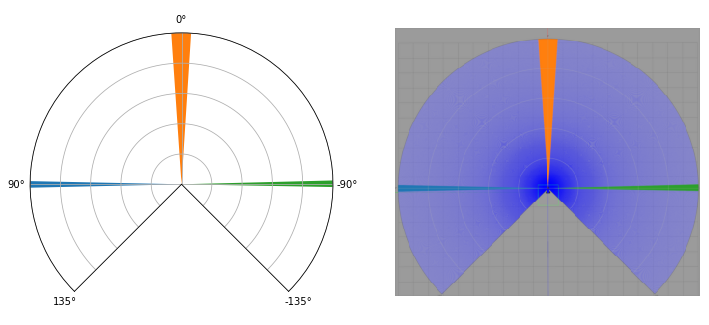

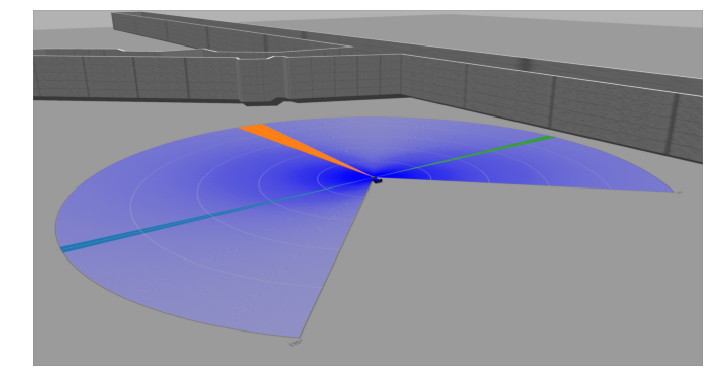

In [3]:
pr = PolarRay(1081, -2.3561944902, 2.3561944902)


fig = plt.figure(figsize=(12,8))
plt1 = fig.add_subplot(1,2,1, polar=True)

plt1.set_yticklabels([])
plt1.set_ylim(0, 1)
plt1.set_thetamin(pr.min_a*180/np.pi)
plt1.set_thetamax(pr.max_a*180/np.pi)
plt1.set_theta_offset(np.pi/2)
plt1.set_xticks([pr.max_a, 90*np.pi/180, 0, -90*np.pi/180, pr.min_a])

r = pr.ray_to_rad(180) 
rw = pr.ray_to_rad(185)-pr.ray_to_rad(175)

c = pr.ray_to_rad(540)
cw = pr.ray_to_rad(555)-pr.ray_to_rad(525)

l = pr.ray_to_rad(900)
lw = pr.ray_to_rad(905)-pr.ray_to_rad(895)

plt1.bar([r],[1], width=rw)
plt1.bar([c],[1], width=cw)
plt1.bar([l],[1], width=lw)

plt2 = fig.add_subplot(1,2,2)
plt2.axis('off')
plt2.imshow(rescale(plt.imread('assets/laser_range.png'), 1/5.0, anti_aliasing=True))
# cv2.imread('./assets/laser_range.png').shape

plt.figure(figsize=(12,8))
plt.axis('off')
plt.imshow(rescale(plt.imread('assets/car_perspective_polar.png'), 1/5.0, anti_aliasing=True))



### Reward function 
$$
R=   \left\{
\begin{array}{ll}
      d_m - 3 - \left| d_l - d_r \right| & \text{if not terminal state} \\
      -100 & \text{otherwise}
\end{array} 
\right.
$$

Where $d_m$ is middle distance, $d_l$ is left distance and $d_r$ is rigth distance, and $d_m, d_l, d_r \in [0, 10]$

The function is implemented in our custom environment [neuroracer_discrete_task.py](neuroracer_gym/src/neuroracer_gym/tasks/neuroracer_discrete_task.py) and looks as follows:
```python
def _compute_reward(self, observations, done):
    if not done:
        rigth_distance, left_distance, middle_distance = self._get_distances()
        reward = (middle_distance - 3)-np.abs(left_distance-rigth_distance)
    else:
        reward = -100
    
    #...
    
    return reward
```


### Evaluation



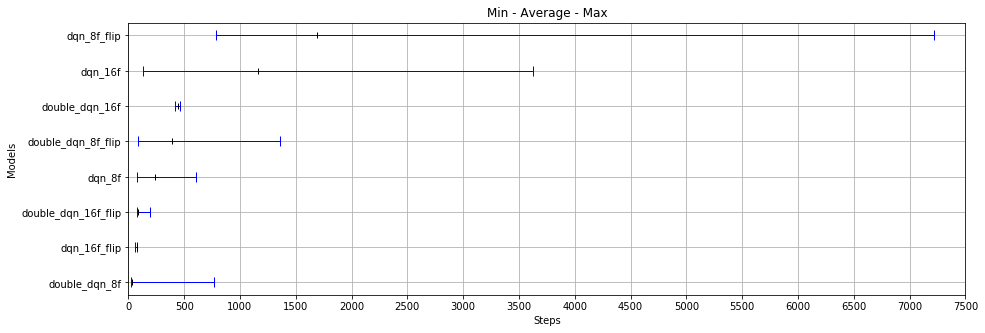

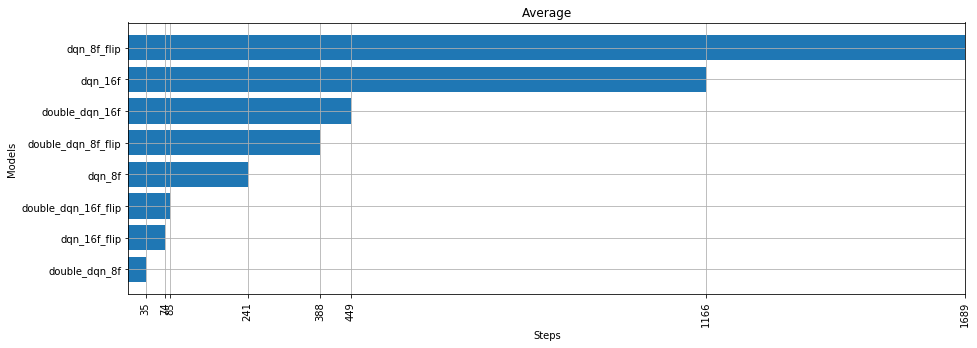

In [214]:
results = {'double_dqn_16f': {'average': 449.44, 'max_steps': 463, 'min_steps': 416},
 'double_dqn_16f_flip': {'average': 84.55, 'max_steps': 198, 'min_steps': 75},
 'double_dqn_8f': {'average': 34.79, 'max_steps': 772, 'min_steps': 20},
 'double_dqn_8f_flip': {'average': 387.71, 'max_steps': 1362, 'min_steps': 91},
 'dqn_16f': {'average': 1166.19, 'max_steps': 3624, 'min_steps': 128},
 'dqn_16f_flip': {'average': 73.52, 'max_steps': 77, 'min_steps': 58},
 'dqn_8f': {'average': 240.82, 'max_steps': 605, 'min_steps': 81},
 'dqn_8f_flip': {'average': 1689.35, 'max_steps': 7218, 'min_steps': 783}}

labels= np.array(results.keys())
results = np.array([[r['average'], r['min_steps'],  r['max_steps']] for r in results.values()])

# fig, ax = plt.subplots(figsize=(10,5))
# pos=np.arange(len(labels))
# width = 0.25
# for i in range(results.shape[1]):
# #     for i, (l, r) in list(enumerate(zip(labels, results[:, p]))):
#     plt.barh(pos+(i*0.25),results[:, i], height=width)

# ax.set_yticks(np.arange(len(labels)) + 1.5 * width)
# ax.set_yticklabels(labels)

# plt.legend(['Average', 'Min', 'Max'])
# ax.set_xlabel('Steps')
# plt.grid()
minmax = results[results[:,0].argsort()]
minmax_l = labels[results[:,0].argsort()]
plt.figure(figsize=(15,5))
mins = minmax[:, 0] - minmax[:, 1]
maxs = minmax[:, 2] -  minmax[:, 0]

plt.errorbar(minmax[:, 0], minmax_l, xerr=[mins, maxs], fmt='|k', lw=1, capsize=5, ecolor='b')
plt.xlabel('Steps')
plt.ylabel('Models')
plt.title('Min - Average - Max')
plt.grid()
plt.xlim(0,7500)
plt.xticks(np.arange(0, 7501, 500),rotation=0)

plt.figure(figsize=(15,5))
plt.barh(minmax_l, minmax[:,0])
# plt.xticks(rotation=30)
plt.xlim(0,minmax[:,0].max()+1)
plt.xticks( minmax[:,0],rotation=90)
plt.ylabel('Models')
plt.xlabel('Steps')
plt.title('Average')
plt.grid()


### Initialization


In [215]:
# Initializing a ROS Node
rospy.init_node('neuroracer_qlearn', anonymous=True, log_level=rospy.INFO)
# loading our custom environment for discrete action space
env = gym.make('NeuroRacer-v0')
# Setting robot's initial position
env.initial_position = {'p_x': np.random.uniform(1,4), 'p_y': 3.7, 'p_z': 0.05, 'o_x': 0, 'o_y': 0.0, 'o_z': np.random.uniform(0.4,1), 'o_w': 0.855}

[ERROR] [1560787851.760311, 1.019000]: SIMULATION RESET
[ERROR] [1560787851.764606, 1.019000]: NOT Initialising Simulation Physics Parameters
[WARN] [1560787851.769403, 1.019000]: Start Init ControllersConnection
[WARN] [1560787851.770852, 1.019000]: END Init ControllersConnection


WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.


In [226]:
img_y_offset = 200
img_y_scale = 0.2
img_x_scale = 0.2

# file_path = 'final_models/double_dqn_16f.h5'
file_path = 'model_backup/dqn_8f.h5'

model = load_model(file_path)

name = file_path[file_path.rfind('/')+1:-3] 
n_frames = int(re.findall('_(\d+)f', name)[0])

img = env.reset()
states = deque(maxlen=n_frames)
for i in range(n_frames):
    states.append(preprocess(img, img_y_offset, img_x_scale, img_y_scale))
done = False
n_steps = 0
while not done:
    n_steps+=1
    action = np.argmax(model.predict(np.expand_dims(np.stack(states, axis=2), axis=0))[0])
    img, reward, done, _ = env.step(action)
    states.append(preprocess(img, img_y_offset, img_x_scale, img_y_scale))

n_steps

[WARN] [1560789474.282306, 8.912000]: DONT RESET CONTROLLERS
[ERROR] [1560789474.310772, 8.936000]: SIMULATION RESET
[WARN] [1560789474.351831, 0.033000]: PUBLISHING REWARD...
[WARN] [1560789474.352941, 0.033000]: PUBLISHING REWARD...DONE=-295.884877204895,EP=7


93

In [ ]:
img_y_offset = 200
img_y_scale = 0.2
img_x_scale = 0.2

f_list = glob.glob("model_backup/*.h5")

results = {}

max_trails = 100
    
for file_path in f_list:
    
    model = load_model(file_path)

    name = file_path[file_path.rfind('/')+1:-3] 
    n_frames = int(re.findall('_(\d+)f', name)[0])

    img = env.reset()
    states = deque(maxlen=n_frames)
    for i in range(n_frames):
        states.append(preprocess(img, img_y_offset, img_x_scale, img_y_scale))
    done = False
    trail=0
    n_steps = 0
    results_steps = []
    while trail<max_trails:
        n_steps+=1
        action = np.argmax(model.predict(np.expand_dims(np.stack(states, axis=2), axis=0))[0])
        img, reward, done, _ = env.step(action)
        states.append(preprocess(img, img_y_offset, img_x_scale, img_y_scale))
        if done:
            results_steps.append(n_steps)
            n_steps = 0
            trail+=1
            done = False
            img = env.reset()
            for i in range(n_frames):
                states.append(preprocess(img, img_y_offset, img_x_scale, img_y_scale))
                
    results[name]= {'max_steps':  max(results_steps), 
                    'min_steps':  min(results_steps), 
                    'average': sum(results_steps) / float(len(results_steps))
                   }
    
results

[WARN] [1560789525.814813, 10.324000]: DONT RESET CONTROLLERS
[ERROR] [1560789525.833768, 10.337000]: SIMULATION RESET
[WARN] [1560789525.875933, 0.032000]: PUBLISHING REWARD...
[WARN] [1560789525.877263, 0.032000]: PUBLISHING REWARD...DONE=9.623387455940247,EP=8
[WARN] [1560789624.778934, 89.521000]: DONT RESET CONTROLLERS
[ERROR] [1560789624.806164, 89.545000]: SIMULATION RESET
[WARN] [1560789624.849672, 0.034000]: PUBLISHING REWARD...
[WARN] [1560789624.850954, 0.034000]: PUBLISHING REWARD...DONE=430.65001744031906,EP=9
[WARN] [1560789692.088440, 61.623000]: DONT RESET CONTROLLERS
[ERROR] [1560789692.115874, 61.648000]: SIMULATION RESET
[WARN] [1560789692.156591, 0.034000]: PUBLISHING REWARD...
[WARN] [1560789692.157603, 0.034000]: PUBLISHING REWARD...DONE=1794.203718394041,EP=10
